In [1]:
import pandas as pd
import numpy as np
import functools as ft
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [3]:
dfs = []
for x in range(2004, 2024):
    y = pd.read_csv(f'data/{x}.csv', sep='\t').dropna(thresh=2).reset_index(drop=True)[['Country', f'{x-1}', f'{x}', f'{x+1}']].rename({
        f'{x-1}': f'{x-1}_in_{x}',
        f'{x}': f'{x}_in_{x}',
        f'{x+1}': f'{x+1}_in_{x}',
    }, axis=1)
    y[f'{x-1}_in_{x}'] = y[f'{x-1}_in_{x}'].astype(str).str.replace(' ', '').str.replace('--', 'NaN').astype(float)
    y[f'{x}_in_{x}'] = y[f'{x}_in_{x}'].astype(str).str.replace(' ', '').str.replace('--', 'NaN').astype(float)
    y[f'{x+1}_in_{x}'] = y[f'{x+1}_in_{x}'].astype(str).str.replace(' ', '').str.replace('--', 'NaN').astype(float)
    dfs.append(y)
df = ft.reduce(lambda left, right: pd.merge(left, right, on='Country'), dfs)
df.dropna(inplace=True)
df.head()

,Country,2003_in_2004,2004_in_2004,2005_in_2004,2004_in_2005,2005_in_2005,2006_in_2005,2005_in_2006,2006_in_2006,2007_in_2006,...,2021_in_2020,2020_in_2021,2021_in_2021,2022_in_2021,2021_in_2022,2022_in_2022,2023_in_2022,2022_in_2023,2023_in_2023,2024_in_2023
0,Antigua and Barbuda,2.5,1.0,0.5,4.1,2.4,2.6,5.0,7.1,3.9,...,4.701,-20.031,0.965,7.019,5.270,6.021,5.629,8.459,5.592,5.417
1,Argentina,8.8,7.0,4.0,9.0,7.5,4.2,9.2,8.0,6.0,...,4.889,-9.905,7.500,2.465,10.398,4.037,2.024,4.956,-2.500,2.750
2,Barbados,2.2,3.0,2.5,4.4,3.1,3.3,3.9,4.2,4.9,...,7.400,-18.000,3.300,8.500,0.700,10.500,5.000,9.800,4.500,3.900
3,Belize,9.4,3.0,3.3,4.6,2.2,2.7,3.5,5.3,2.6,...,8.000,-14.038,8.500,5.400,16.342,3.502,1.998,12.726,4.007,2.998
4,Bolivia,2.5,3.8,4.5,3.6,3.9,2.5,4.1,4.1,3.9,...,5.600,-8.829,4.950,4.000,6.106,3.800,3.200,3.478,1.800,1.800


In [4]:
df[df['Country'] == 'Guyana'][['2020_in_2021', '2021_in_2022', '2022_in_2023']]

,2020_in_2021,2021_in_2022,2022_in_2023
15,43.48,23.774,62.288


In [5]:
# wtf?!
df = df[df['Country'] != 'Guyana']

In [6]:
for x in range(2004, 2023):
    df[f'expected_growth_{x}_t'] = df[f'{x}_in_{x}'].astype(float)
    df[f'expected_growth_{x}_t1'] = df[f'{x+1}_in_{x}'].astype(float)
    df[f'actual_growth_{x}'] = df[f'{x}_in_{x+1}'].astype(float)
df[['expected_growth_2008_t', 'expected_growth_2008_t1', 'actual_growth_2008']].head()

,expected_growth_2008_t,expected_growth_2008_t1,actual_growth_2008
0,2.092,4.009,2.800
1,6.500,3.600,6.758
2,1.700,1.000,0.180
3,4.000,2.500,3.771
4,5.900,5.000,6.100


In [7]:
base = {}
for x in range(2005, 2023):
    base[f'year_{x}'] = 0
for c in df['Country'].unique():
    base[f'country_{c}'] = 0

table = []
for x in range(2005, 2023):
    for c in df['Country'].unique():
        table.append({
            **base,
            'country': c,
            f'year_{x}': 1,
            f'country_{c}': 1,
            'expected_growth_t': df[f'expected_growth_{x}_t'][df['Country'] == c].iloc[0],
            'expected_growth_t1': (df[f'expected_growth_{x}_t1'][df['Country'] == c].iloc[0] - df[f'expected_growth_{x}_t'][df['Country'] == c].iloc[0]) / (df[f'expected_growth_{x}_t1'][df['Country'] == c].iloc[0] - df[f'expected_growth_{x}_t'][df['Country'] == c].iloc[0]+.0001),
            'actual_growth': df[f'actual_growth_{x}'][df['Country'] == c].iloc[0],
        })
X = pd.DataFrame(table).drop(['country_Mexico', 'year_2005'], axis=1)
groups = X['country']
X.drop('country', axis=1, inplace=True)
X.head()

,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,...,country_St. Kitts and Nevis,country_St. Lucia,country_St. Vincent and the Grenadines,country_Suriname,country_Trinidad and Tobago,country_Uruguay,country_Venezuela,expected_growth_t,expected_growth_t1,actual_growth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,0.999500,5.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.5,1.000030,9.2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.1,0.999500,3.9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.2,0.999800,3.5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.9,1.000071,4.1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          actual_growth   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              1218.
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                    1.26e-24
Time:                        22:06:14   Log-Likelihood:                         -1098.4
No. Observations:                 522   AIC:                                      2199.
Df Residuals:                     521   BIC:                                      2203.
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
expected_growth_t     1.0639      0.030     34.907      0.000       1.004       1.124
==============================================================================
Omnibus:                      186.671   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2430.903
Skew:                           1.178   Prob(JB):                         0.00
Kurtosis:                      13.306   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are robust to cluster correlation (cluster)
"""

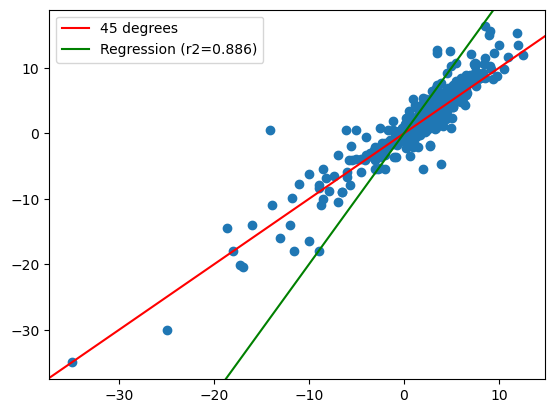

In [8]:
plt.scatter(X['expected_growth_t'], X['actual_growth'])
plt.axline([0, 0], [1, 1], color='red', label='45 degrees')
model = sm.OLS(X['actual_growth'], X['expected_growth_t'])
fitted_model = model.fit(cov_type='cluster', cov_kwds={'groups': groups})
x = np.arange(1, 3)
plt.axline(x, fitted_model.params.expected_growth_t * x, color='green', label=f'Regression (r2={fitted_model.rsquared:.3g})')
plt.legend(loc="upper left")
fitted_model.summary()

In [9]:
y = X['actual_growth']
model = sm.OLS(y, sm.add_constant(X.drop(['actual_growth', 'expected_growth_t1'], axis=1)))
fitted_model = model.fit(cov_type='cluster', cov_kwds={'groups': groups})
fitted_model.summary()

/home/seppo/.local/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          actual_growth   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     13.00
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.50e-09
Time:                        22:06:14   Log-Likelihood:                -1044.5
No. Observations:                 522   AIC:                             2183.
Df Residuals:                     475   BIC:                             2383.
Df Model:                          46                                         
Covariance Type:              cluster                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.7814      0.328      2.385      0.017       0.139       1.424
year_2006                                  0.0904      0.364      0.248      0.804      -0.623       0.804
year_2007                                 -0.5084      0.379     -1.340      0.180      -1.252       0.235
year_2008                                 -1.3348      0.326     -4.093      0.000      -1.974      -0.696
year_2009                                 -1.0320      0.518     -1.991      0.046      -2.048      -0.016
year_2010                                 -0.3371      0.426     -0.791      0.429      -1.172       0.498
year_2011                                 -1.2910      0.484     -2.668      0.008      -2.239      -0.343
year_2012                                 -0.9093      0.331     -2.750      0.006      -1.557      -0.261
year_2013                                 -0.6599      0.295     -2.240      0.025      -1.237      -0.083
year_2014                                 -0.6584      0.257     -2.560      0.010      -1.162      -0.154
year_2015                                 -1.0493      0.410     -2.558      0.011      -1.853      -0.245
year_2016                                 -1.2450      0.394     -3.163      0.002      -2.016      -0.474
year_2017                                 -1.2441      0.546     -2.278      0.023      -2.315      -0.174
year_2018                                 -0.3866      0.474     -0.815      0.415      -1.316       0.543
year_2019                                 -1.5229      0.376     -4.055      0.000      -2.259      -0.787
year_2020                                 -1.3466      1.053     -1.279      0.201      -3.409       0.716
year_2021                                  1.2352      0.680      1.817      0.069      -0.097       2.567
year_2022                                 -0.0868      0.514     -0.169      0.866      -1.095       0.921
country_Antigua and Barbuda                0.7175      0.050     14.450      0.000       0.620       0.815
country_Argentina                          0.9967      0.045     22.223      0.000       0.909       1.085
country_Barbados                          -0.9441      0.047    -20.021      0.000      -1.037      -0.852
country_Belize                             0.6124      0.014     45.052      0.000       0.586       0.639
country_Bolivia                            0.1419      0.131      1.079      0.281      -0.116       0.400
country_Brazil                            -0.1479      0.004    -36.813      0.000      -0.156      -0.140
country_Chile                             -0.2272      0.115     -1.984      0.047      -0.452      -0.003
country_Colombia                           0.4448      0.113      3.948      0.000     

In [10]:
y = X['actual_growth']
model = sm.OLS(y, sm.add_constant(X.drop(['actual_growth'], axis=1)))
fitted_model = model.fit(cov_type='cluster', cov_kwds={'groups': groups})
fitted_model.summary()

/home/seppo/.local/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 19
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          actual_growth   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     13.32
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.13e-09
Time:                        22:06:14   Log-Likelihood:                -1044.5
No. Observations:                 522   AIC:                             2185.
Df Residuals:                     474   BIC:                             2389.
Df Model:                          47                                         
Covariance Type:              cluster                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6959      0.406      1.714      0.087      -0.100       1.492
year_2006                                  0.0836      0.368      0.227      0.820      -0.637       0.805
year_2007                                 -0.5254      0.387     -1.358      0.174      -1.283       0.233
year_2008                                 -1.3517      0.335     -4.035      0.000      -2.008      -0.695
year_2009                                 -1.0490      0.531     -1.975      0.048      -2.090      -0.008
year_2010                                 -0.3507      0.435     -0.807      0.420      -1.203       0.501
year_2011                                 -1.3079      0.495     -2.644      0.008      -2.277      -0.339
year_2012                                 -0.9229      0.329     -2.802      0.005      -1.568      -0.277
year_2013                                 -0.6667      0.300     -2.220      0.026      -1.255      -0.078
year_2014                                 -0.6651      0.258     -2.580      0.010      -1.170      -0.160
year_2015                                 -1.0663      0.423     -2.522      0.012      -1.895      -0.238
year_2016                                 -1.2518      0.395     -3.170      0.002      -2.026      -0.478
year_2017                                 -1.2577      0.553     -2.275      0.023      -2.341      -0.174
year_2018                                 -0.4002      0.469     -0.853      0.394      -1.320       0.519
year_2019                                 -1.5366      0.385     -3.991      0.000      -2.291      -0.782
year_2020                                 -1.3637      1.054     -1.294      0.196      -3.429       0.701
year_2021                                  1.2182      0.677      1.801      0.072      -0.108       2.544
year_2022                                 -0.1038      0.506     -0.205      0.837      -1.096       0.888
country_Antigua and Barbuda                0.7175      0.050     14.433      0.000       0.620       0.815
country_Argentina                          0.9967      0.045     22.198      0.000       0.909       1.085
country_Barbados                          -0.9386      0.050    -18.684      0.000      -1.037      -0.840
country_Belize                             0.6178      0.020     30.869      0.000       0.579       0.657
country_Bolivia                            0.1473      0.132      1.117      0.264      -0.111       0.406
country_Brazil                            -0.1479      0.004    -36.752      0.000      -0.156      -0.140
country_Chile                             -0.2271      0.115     -1.981      0.048      -0.452      -0.002
country_Colombia                           0.4503      0.113      3.978      0.000     

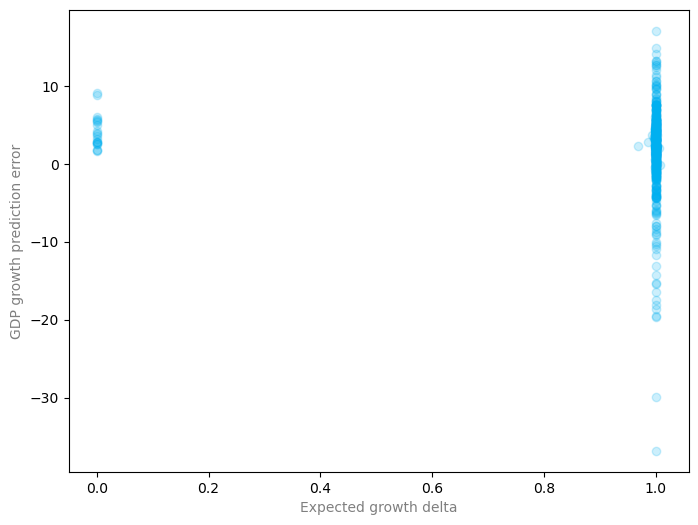

In [11]:
y_pred = fitted_model.predict(X)
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X['expected_growth_t1'], y - y_pred, color=COLORS[0], label='Observed', alpha=.2)
plt.xlabel('Expected growth delta', alpha=.5)
plt.ylabel('GDP growth prediction error', alpha=.5)

plt.show()